In [1]:
import torch
import numpy as np
import trimesh
import flexicubes
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.io as pio
pio.renderers.default = 'iframe'
from skimage import measure
import mesh_to_sdf
import trimesh

In [41]:
def render_mesh(verts, faces):
    fig = go.Figure(data=[go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        opacity=0.7,
        colorscale="Jet",
    )])
    fig.show()

def render_static(verts, faces):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    plt.tight_layout()
    plt.show()

def render_trimesh(verts, faces):
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    mesh.show()

def render(verts, faces):
    render_static(verts, faces)
    render_mesh(verts, faces)
    render_trimesh(verts, faces)

In [3]:
def cube_sdf(x_nx3):
    sdf_values = 0.5 - torch.abs(x_nx3)
    sdf_values = torch.clamp(sdf_values, min=0.0)
    sdf_values = sdf_values[:, 0] * sdf_values[:, 1] * sdf_values[:, 2]
    sdf_values = -2.0 * sdf_values

    return sdf_values


def cube_sdf_gradient(x_nx3):
    gradients = []
    for i in range(x_nx3.shape[0]):
        x, y, z = x_nx3[i]
        grad_x, grad_y, grad_z = 0, 0, 0

        max_val = max(abs(x) - 0.5, abs(y) - 0.5, abs(z) - 0.5)

        if max_val == abs(x) - 0.5:
            grad_x = 1.0 if x > 0 else -1.0
        if max_val == abs(y) - 0.5:
            grad_y = 1.0 if y > 0 else -1.0
        if max_val == abs(z) - 0.5:
            grad_z = 1.0 if z > 0 else -1.0

        gradients.append(torch.tensor([grad_x, grad_y, grad_z]))

    return torch.stack(gradients).to(x_nx3.device)

In [115]:
res = 5
device='cpu'
fc = flexicubes.FlexiCubes(device)
voxelgrid_vertices, cube_idx = fc.construct_voxel_grid(res)
voxelgrid_vertices *= 1.1
scalar_field = cube_sdf(voxelgrid_vertices)

mesh_with_grad_v, mesh_with_grad_f, something = fc(
    voxelgrid_vertices, scalar_field, cube_idx, res,
    grad_func=cube_sdf_gradient)

mesh_no_grad_v, mesh_no_grad_f, something_no_grad = fc(
    voxelgrid_vertices, scalar_field, cube_idx, res)

In [116]:
def flexicubes_to_dense(vertices, scalar_field, resolution):
    xs = np.unique(vertices[:, 0])
    ys = np.unique(vertices[:, 1])
    zs = np.unique(vertices[:, 2])
    nx, ny, nz = len(xs), len(ys), len(zs)

    x_to_i = {x: i for i, x in enumerate(xs)}
    y_to_j = {y: j for j, y in enumerate(ys)}
    z_to_k = {z: k for k, z in enumerate(zs)}

    volume = np.zeros((nx, ny, nz), dtype=np.float32)
    for v, val in zip(vertices, scalar_field):
        i = x_to_i[v[0]]
        j = y_to_j[v[1]]
        k = z_to_k[v[2]]
        volume[i, j, k] = val
    return volume

volume_data = flexicubes_to_dense(
    voxelgrid_vertices.cpu().numpy(),
    scalar_field,
    res
)
volume_data = np.pad(volume_data, 1, mode='constant', constant_values=+1.0)

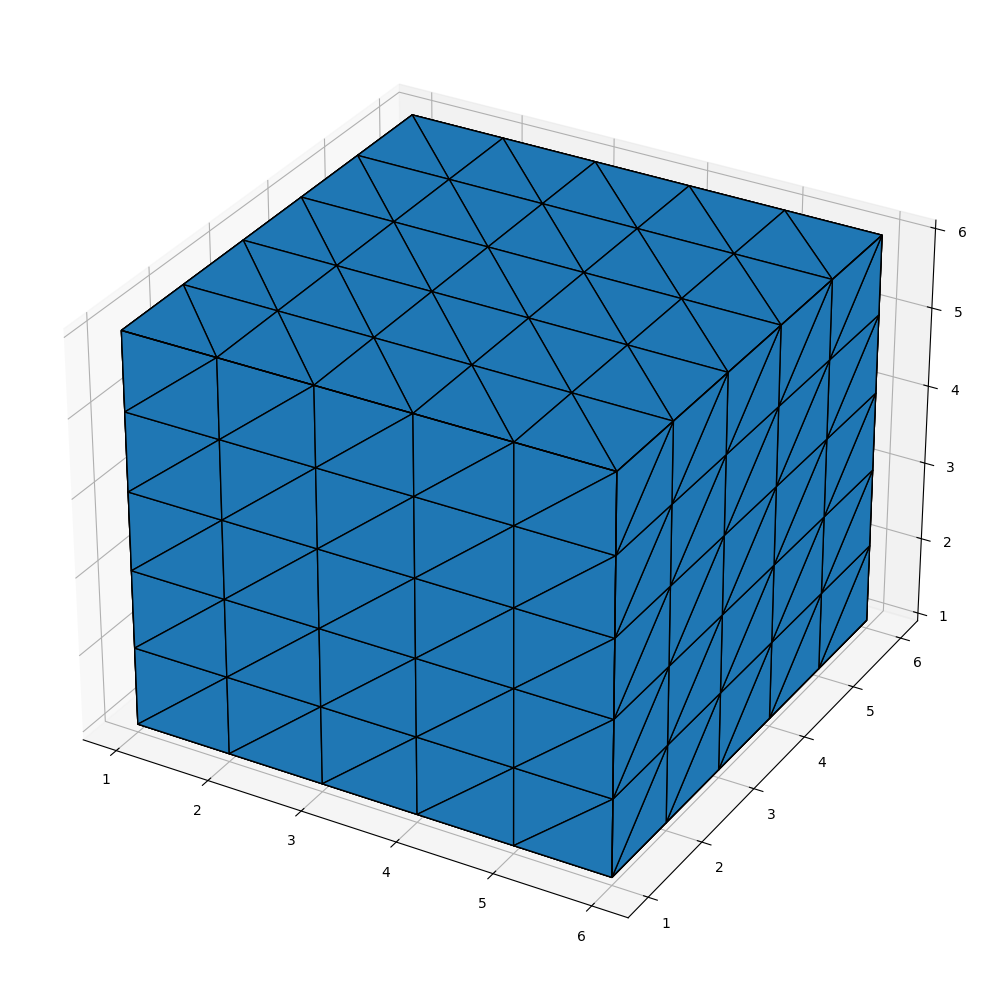

In [117]:
verts, faces, normals, values = measure.marching_cubes(volume_data, 0)
render(verts, faces)

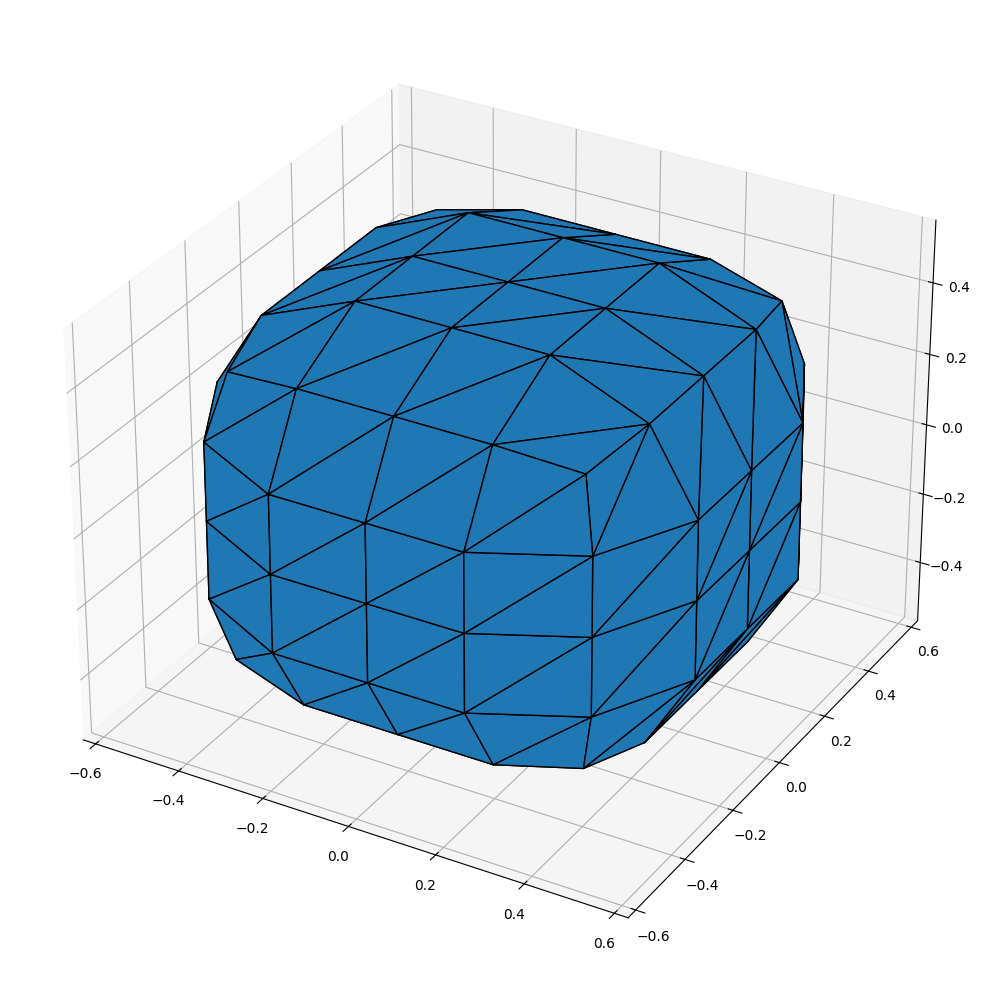

In [118]:
render(mesh_no_grad_v.cpu(), mesh_no_grad_f.cpu())

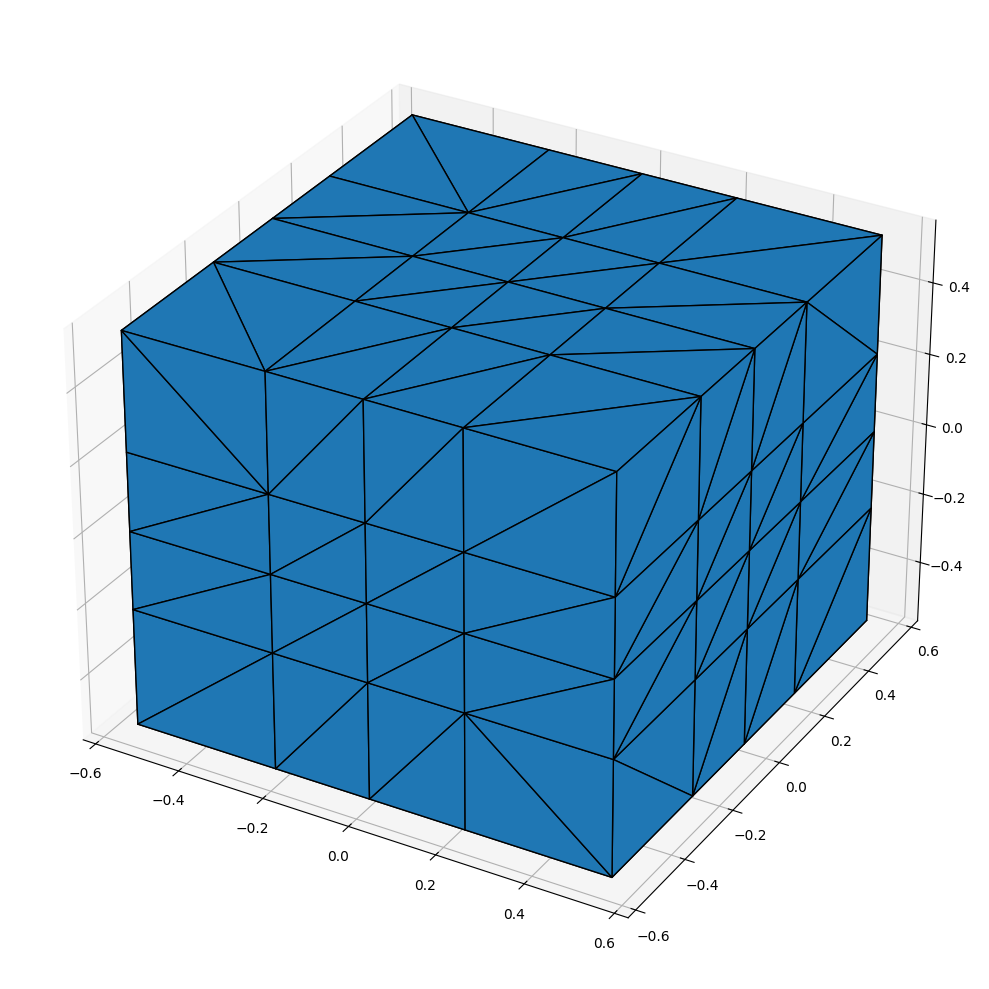

In [119]:
render(mesh_with_grad_v.cpu(), mesh_with_grad_f.cpu())

In [120]:
res = 64
mesh = trimesh.load("./chair.obj")
mesh = mesh_to_sdf.scale_to_unit_cube(mesh)
mesh.apply_translation(-mesh.centroid)
mesh.apply_scale(1.0 / mesh.scale)
point_cloud = mesh_to_sdf.get_surface_point_cloud(
    mesh, surface_point_method='scan', scan_count=20, scan_resolution=400
)
mesh.show()

Context leak detected, CoreAnalytics returned false
Context leak detected, CoreAnalytics returned false
Context leak detected, CoreAnalytics returned false


In [121]:
verts, faces, normals, _ = measure.marching_cubes(
    point_cloud.get_voxels(res, use_depth_buffer=True), 0)

mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
mesh.show()

In [122]:
fc = flexicubes.FlexiCubes(device)
voxelgrid_vertices, cube_idx = fc.construct_voxel_grid(res)
scalar_field = torch.Tensor(
    point_cloud.get_sdf(voxelgrid_vertices.cpu().numpy(), use_depth_buffer=True)
).to(device)

v, f, _ = fc(
    voxelgrid_vertices, scalar_field, cube_idx, res
)
trimesh.Trimesh(vertices=v.cpu().numpy(), faces=f.cpu().numpy()).show()

In [123]:
mesh = trimesh.load("./bun_zipper.ply")
mesh = mesh_to_sdf.scale_to_unit_cube(mesh)
mesh.apply_translation(-mesh.centroid)
mesh.apply_scale(1.0 / mesh.scale)
point_cloud = mesh_to_sdf.get_surface_point_cloud(
    mesh, surface_point_method='scan', scan_count=20, scan_resolution=400
)
mesh.show()

In [124]:
verts, faces, normals, _ = measure.marching_cubes(
    point_cloud.get_voxels(res, use_depth_buffer=True), 0)

mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
mesh.show()

In [125]:
fc = flexicubes.FlexiCubes(device)
voxelgrid_vertices, cube_idx = fc.construct_voxel_grid(res)
scalar_field = torch.Tensor(
    point_cloud.get_sdf(voxelgrid_vertices.cpu().numpy(), use_depth_buffer=True)
).to(device)

v, f, _ = fc(
    voxelgrid_vertices, scalar_field, cube_idx, res
)
trimesh.Trimesh(vertices=v.cpu().numpy(), faces=f.cpu().numpy()).show()